## Configure environment

In [1]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  if not os.path.exists("/data/video_prediction_dataset.hdf5"):
    !gdown 1fYtaFcGKSL8ykJFbewAFsFf9C4aW0DuV
    !gdown 1VILdkCRWsDTrN9DPeMLh8jlibAoBLzy-
    !gdown 197pDAI8KVsiDAA1xaPbitZpmvzh9CDqT
    !gdown 1XqgXAtxWUdnBJnvQTtEr8JpBkVi3JuSC
    !gdown 1_DVttDvwxCm_QGDxU2tbaaclWKd1VCau
    %mkdir -p /data
    %mv /content/*.hdf5 /data/
    %mv /content/*.npy /data/

In [4]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'ConvLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

In [5]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import xarray as xr

from ConvLSTMmodels import ConvLSTM, EncoderRNN, ConvLSTMEncoderDecoder, Seq2SeqConvLSTM
if not IN_COLAB:
  sys.path.append('../common')
import common

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
if not IN_COLAB:
  common.set_memory_limit_if_not_limit(1.5)

In [9]:
os.makedirs('save', exist_ok=True)

## Load data

In [10]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
model_name = 'ConvLSTM'
output_path = os.path.join(cwd, "save", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [11]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 64, phony_dim_4: 3)> Size: 878MB
[878247936 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 64, 3)


In [12]:
times_curr_train = np.load(os.path.join(data_folder,"times_curr_trainval.npy"),allow_pickle=True)
times_curr_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)

print('-'*50)
print("times_curr_train.shape:", times_curr_train.shape)
print("images_log_train.shape:", dss['trainval']['images_log'].shape)
print("images_pred_train.shape:", dss['trainval']['images_pred'].shape)
print("times_curr_test.shape:", times_curr_test.shape)
print("images_log_test.shape:", dss['test']['images_log'].shape)
print("images_pred_test.shape:", dss['test']['images_pred'].shape)
print('-'*50)

# get the input dimension for constructing the model
num_log_frame = dss['trainval']['images_log'].shape[1]
img_side_len = dss['trainval']['images_log'].shape[2]
num_color_channel = dss['trainval']['images_log'].shape[4]
num_pred_frame = dss['trainval']['images_pred'].shape[1]
image_log_dim = [num_log_frame,img_side_len,img_side_len,num_color_channel]
image_pred_dim = [num_pred_frame,img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of log frames:", num_log_frame)
print("number of pred frames:", num_pred_frame)
print("number of color channels:", num_color_channel)
print("context(log) image dimension:", image_log_dim)
print("future(pred) image dimension:", image_pred_dim)

--------------------------------------------------
times_curr_train.shape: (53336,)
images_log_train.shape: (53336, 16, 64, 64, 3)
images_pred_train.shape: (53336, 15, 64, 64, 3)
times_curr_test.shape: (4467,)
images_log_test.shape: (4467, 16, 64, 64, 3)
images_pred_test.shape: (4467, 15, 64, 64, 3)
--------------------------------------------------
image side length: 64
number of log frames: 16
number of pred frames: 15
number of color channels: 3
context(log) image dimension: [16, 64, 64, 3]
future(pred) image dimension: [15, 64, 64, 3]


In [13]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)


(4096, 4)
1674
2422
4096


In [14]:
bs = 16 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    #v2.functional.adjust_contrast(),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Lambda(v2.functional.autocontrast),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.float()),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 53336.
Number of video batches: 3334
Size of video batches: 16.


torch.Size([16, 3, 64, 64])
Number of images per video: 16
Number of images per batch: 256


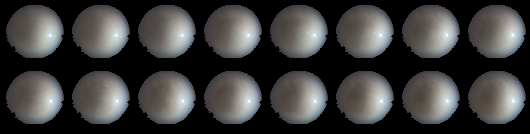

In [15]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_loader))
print(fixed_x[0].shape) # 0 because VideoDataset has batch_size videos, not images.
print(f"Number of images per video: {fixed_x[0].shape[0]}")
print(f"Number of images per batch: {fixed_x[0].shape[0]*bs}")
torchvision.utils.save_image(fixed_x[0], 'save/real_image.png')
idisplay.Image('save/real_image.png')

## Model

In [16]:
clstm = Seq2SeqConvLSTM(3, 16, (3, 3), 1)

last_epoch = 0
if os.path.exists(output_path):
    clstm.load_state_dict(torch.load(output_path, map_location='cpu'))
    last_epoch = 25
else:
    print('No states loaded')

No states loaded


In [17]:
def show(data):
    torchvision.utils.save_image(data, 'save/sample_image.png')
    display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))

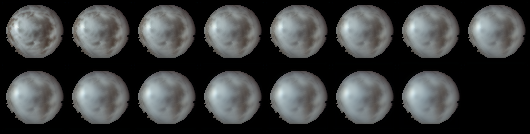

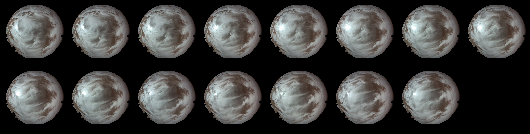

In [36]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())

## Training

In [19]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(clstm.parameters(), lr=1e-3)
epochs = 30

# Scheduled sampling parameters
initial_teacher_forcing_ratio = 1.0
final_teacher_forcing_ratio = 0.1
scheduled_sampling_decay = 0.3  # decay rate per epoch

clstm.train()

for epoch in range(last_epoch, epochs):
    teacher_forcing_ratio = final_teacher_forcing_ratio + (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * math.exp(-scheduled_sampling_decay * epoch)
    print(f"Epoch[{epoch+1}/{epochs}] teacher_forcing_ratio: {teacher_forcing_ratio}")
    for idx, (videos, targets) in enumerate(train_loader):
        #clstm.zero_grad()
        outputs = clstm(videos, targets.size(1), targets, teacher_forcing_ratio)
        loss = loss_function(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}]"
                f" Loss: {loss.data.item()/bs:.4g} "
            )
            print(to_print)
    torch.save(clstm.state_dict(), output_path)

Epoch[1/30] teacher_forcing_ratio: 1.0
Epoch[1/30] B[1/3334] Loss: 0.01001 
Epoch[1/30] B[11/3334] Loss: 0.005467 
Epoch[1/30] B[21/3334] Loss: 0.001691 
Epoch[1/30] B[31/3334] Loss: 0.001236 
Epoch[1/30] B[41/3334] Loss: 0.0007989 
Epoch[1/30] B[51/3334] Loss: 0.000642 
Epoch[1/30] B[61/3334] Loss: 0.0004368 
Epoch[1/30] B[71/3334] Loss: 0.0004742 
Epoch[1/30] B[81/3334] Loss: 0.0003482 
Epoch[1/30] B[91/3334] Loss: 0.0002566 
Epoch[1/30] B[101/3334] Loss: 0.0002652 
Epoch[1/30] B[111/3334] Loss: 0.0002762 
Epoch[1/30] B[121/3334] Loss: 0.0002431 
Epoch[1/30] B[131/3334] Loss: 0.0002328 
Epoch[1/30] B[141/3334] Loss: 0.0002452 
Epoch[1/30] B[151/3334] Loss: 0.0002288 
Epoch[1/30] B[161/3334] Loss: 0.000179 
Epoch[1/30] B[171/3334] Loss: 0.0002431 
Epoch[1/30] B[181/3334] Loss: 0.0001729 
Epoch[1/30] B[191/3334] Loss: 0.0001583 
Epoch[1/30] B[201/3334] Loss: 0.0001683 
Epoch[1/30] B[211/3334] Loss: 0.0002011 
Epoch[1/30] B[221/3334] Loss: 0.0002156 
Epoch[1/30] B[231/3334] Loss: 0.0002

KeyboardInterrupt: 

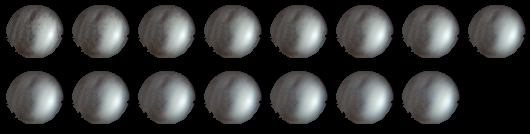

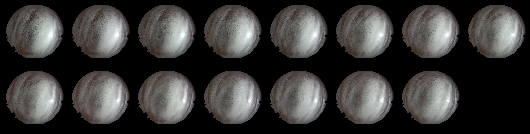

In [37]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())

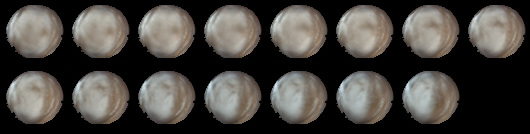

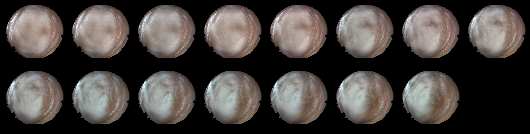

In [42]:
# Predict with always given the true target value for previous calcs
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15, target_video.unsqueeze(0), 1).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())